# Predictive Models
---
# 1 - Introduction

Now that we have cleaned our dataset and created some derived features, we are ready to start building predictive models.
We are attempting to build two types of predictive models.
1. Supervised learning
  * Train the model using labeled data
  * Predict whether a student gets certified for their course
    * certified=0 -> Student does not get certified
    * certified=1 -> Student gets certified
    * Binary classification problem
2. Unsupervised learning
  * Train the model with un-labeled data
  * Group students into clusters based on their features

## 1.1 - Import Libraries
We will be using pandas dataframes, matplotlib for visualizations, and scikit learn for the machine learning algorithms for this notebook. Additionally, we will use the random package for some random numbers.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from sklearn import preprocessing
import random
import math
import numpy as np

## 1.2 - Import Clean Data
To make sure we all start with the clean data produced from the first part of this tutorial, we will import the cleaned data into a dataframe and work with it from there.

In [2]:
cleaned_df_all = pd.DataFrame.from_csv("./data/cleaned_data.csv")
cleaned_df_all.head()

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,...,nchapters,nforum_posts,roles,incomplete_flag,Age,english_speaking,Country_US,education,college,ageGroup
19330,HarvardX/CS50x/2012,MHxPC130422039,1,0,0,0,Unknown/Other,Secondary,1987.0,m,...,0.0,0,0.0,0.0,25.0,0,other,0,HarvardX,25-34
19331,HarvardX/CS50x/2012,MHxPC130407931,1,0,0,0,United States,Secondary,1968.0,f,...,0.0,0,0.0,0.0,44.0,1,United States,0,HarvardX,35-44
19332,HarvardX/PH207x/2012_Fall,MHxPC130313697,1,0,0,0,India,Bachelor's,1989.0,m,...,0.0,0,0.0,0.0,23.0,1,other,1,HarvardX,0-24
19333,HarvardX/CS50x/2012,MHxPC130064950,1,0,0,0,Unknown/Other,Master's,1978.0,m,...,0.0,0,0.0,0.0,34.0,0,other,2,HarvardX,25-34
19334,HarvardX/PH207x/2012_Fall,MHxPC130237753,1,1,0,0,United States,Secondary,1993.0,m,...,2.0,0,0.0,0.0,19.0,1,United States,0,HarvardX,0-24


---
# 2 - Binary Classification using Logistic Regression

Binary classification problems are very common in several areas which utilize machine learning. 
Some examples of common binary classification problems are:

* Predicting if a patient does or does not have a disease
* Predicting if an email is spam or not
* Predicting if a student will drop out of high school or not

There are several advanced methods for binary classification such as decision trees, random forests, and neural networks to name a few.
For our exercises, we will utilize [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) for our binary classification to determine if students will obtain certification in their course or not.

## 2.1 - Logistic Regression Basics
Logistic regression is similar to standard linear regression in that it is centered on a linear equation for prediction.
Specifically, the goal is to determine the best fitted Beta parameters given features x. ![alt text](https://upload.wikimedia.org/math/1/e/6/1e673e003f3880eebd73d5043e80c07c.png "Linear Equation")
In the simple case of 1 feature, the linear equation is ![alt text](https://upload.wikimedia.org/math/c/7/3/c739c3018912dbc27b4c2799e8dc8033.png "Basic Linear Equation") where x is the singular feature.
The probability for a 1 label, in our case the probability for that a given student will obtain a certificate, is given by the sigmoid of the linear equation. ![alt text](https://upload.wikimedia.org/math/5/6/f/56fc4a24b7084ff8f218aaeb5bfe1c4e.png "Success Probability")
The sigmoid function as the desirable property that is outputs numbers between 0 and 1 no matter the input value.
This is the perfect property for binary classification where we expect the probability of a 1 label to exist between 0 and 1.
We will quickly make a plot demonstrating the shape of the sigmoid function over a wide span of input values, t.

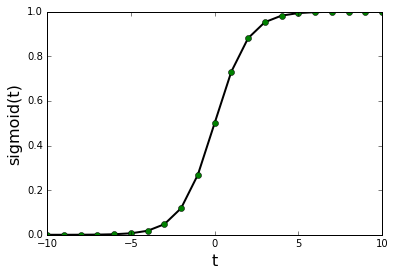

In [3]:
def sigmoid(t):
    return 1.0 / (1.0 + math.exp(-t))

t = range(-10, 11); f = [sigmoid(i) for i in t]
plt.plot(t,f,'k', linewidth=2)
plt.plot(t,f,'go')
plt.xlabel('t', fontsize=16)
plt.ylabel('sigmoid(t)', fontsize=16)
plt.show()

Once the fitting parameters (Betas) are found, the value of t can be found for any set of feature inputs.
The predicting probability for a 1 label for the set of features is found using the sigmoid on t.
The threshold for success from the sigmoid can also be altered.
Most machine learning packages have the default threshold as 0.5, but this can be optimized for specific situations.
For example, classifiers for the existence of a tumor in a patient might lower the threshold from 0.5 to 0.2 to ensure a higher true-postitive rate at the cost of an increased false-positive rate.

---
## 2.2 - Simple Example with Logistic Regression
Let's us some fake data from [Wikapedia](https://en.wikipedia.org/wiki/Logistic_regression#Example:_Probability_of_passing_an_exam_versus_hours_of_study)  on students studying to pass a test.
We will start with data for a few students on how many hours they studied, and a binary label for if they passed the test or not.
Using this data, we will fit a logistic regression model for an intercept and a weight for the feature (B0 and B1).
We will then be able to use the fit parameters to predict if a student passes given the number of hours they study.

### 2.2.1 - Define the data to train the classifier
A list of tuples, where each tuple has (number_of_hours_studied, passed_test) where number_of_hours_studied is a float and passed_test is a binary label. 

In [4]:
training_example_data  = [(0.5, 0), (0.75, 0), (1.0, 0), (1.25, 0), (1.5, 0), (1.75, 0), (1.75, 1)]
training_example_data += [(2.0, 0), (2.25, 1), (2.5, 0), (2.75, 1), (3.0, 0), (3.25, 1), (3.5, 0)]
training_example_data += [(4.0, 1), (4.25, 1), (4.5, 0), (4.75, 1), (5.0, 1), (5.5, 1)]

# Note: we make both lists into numpy arrays and reshape the X data into the correct format
# this is only needed when using a single feature
X_train_example = np.asarray([x[0] for x in training_example_data]).reshape(-1,1)
Y_train_example = np.asarray([x[1] for x in training_example_data])

### 2.2.2 - Using scikit-learn, train a classifier using logistic regression

In [5]:
# Create a logistic regression model from scikit learn
logreg_example = linear_model.LogisticRegression()

# Fit the logistic regression model using the training data
logreg_example.fit(X_train_example, Y_train_example)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### 2.2.3 - Using the trained classifier, plot its predictions over a range of study times

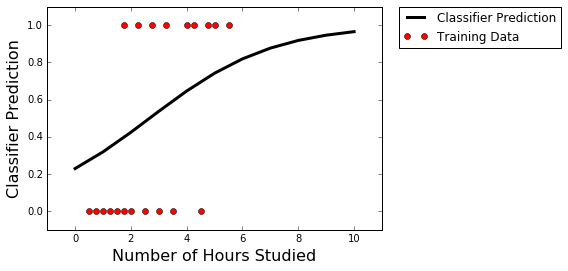

In [6]:
# Define a list of hours to get predictions from the classifier
hours = np.asarray(range(0,11))

# Get predictions for every hour
both_predictions = logreg_example.predict_proba(hours.reshape(-1,1))
predictions = [x[1] for x in both_predictions]
    
# Create a plot of the classifer prediction vs number of hours studied
plt.plot(hours, predictions, 'k', linewidth=3, label='Classifier Prediction')
plt.plot(X_train_example, Y_train_example, 'ro', label='Training Data')
plt.xlabel('Number of Hours Studied', fontsize=16)
plt.ylabel('Classifier Prediction', fontsize=16)
plt.xlim([-1, 11]); plt.ylim([-0.1, 1.1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 2.2.4 - Simple logistic regression example overview
We have now trained our first logistic regression classifier, which predicts if a student will pass a test given a single feature of how many hours the student studied for the test.
We will now use this knowledge to build a logistic regression classifier to predict whether a student obtained a certificate or not in their MOOC from the HarvardX-MITx dataset.

---

## 2.3 - Step-by-step Binary Classification
We need to think about our features as a first step to building our classifier.
Let's narrow our features down to the following list:

### Feature List
* _Student Traits_ - Features about the individual student not related to their interaction with the course at all
  * __english_speaking__ (binary) student lives in an English speaking country
  * __education__ (int) {"Bachelor's": 1, "Doctorate": 4, "Less than Secondary": 5, "Master's": 2, "None": 3, "Secondary": 0}
  * __Age__ (int) student age in years
* _Course Interactions_ - Features about the individual student interacting with the different aspects of the course
  * __nplay_video__ (int) number of videos the student played within the course
  * __nforum_posts__ (int) number of times the student posted to the forum for the course
* _Super Features_ - Features which are extremely predictive
  * __nevents__ (int) number of times the student interacted with the course
  * __nchapters__ (int) number of chapters within the course that the student interacted with

Let's start by defining lists for our diffent feature groups which we will use to filter the full dataset dataframe.

In [7]:
student_trait_features      = ["english_speaking", "education", "Age"]
course_interaction_features = ["nplay_video", "nforum_posts"]
super_features              = ["nevents", "nchapters"]

We will now develop a logisic regression classifier using only the student_traits_features.
We will accomplish this step-by-step at first, followed by building a simple function utilizing all the steps.

### Step 1: Getting a subset of the dataset for a list of features and creating training/testing datasets
We will start by only using the student trait features to build our classifier.

In [8]:
# Define a list of column names to keep from the main dataset
# We are specifically putting the classifcation label column "certified"
# as the last element of the list
features_label = student_trait_features + ["certified"]

# Get a new dataframe that only contains columns from the features_label list
cleaned_df = cleaned_df_all[features_label]
print("Total of "+str(cleaned_df.shape[0])+" datapoints")
cleaned_df.head()

Total of 535641 datapoints


,english_speaking,education,Age,certified
19330,0,0,25.0,0
19331,1,0,44.0,0
19332,1,1,23.0,0
19333,0,2,34.0,0
19334,1,0,19.0,0


We now have a dataframe with clean data that we can use to build a model which predicts if a student will obtain a certificate in the course or not. 
We will now split our data into training and testing datasets. 
We will do this using a 80/20 split of the original data giving the larger chunk of 80% of the data to the training set. 
The data split should be random and deterministic, so a seed will be used for the randomization of the data split.
We will use the train_test_split method to randomly split the data.

In [9]:
# Create a list of datapoints from the dataframe
# Each element in the list will be a tuple with the form (label, features)
# where label is either 1 or 0, and features is a list of the features from the dataframe
clean_datapoints = map(list, cleaned_df.values)
clean_labeledpoints = [(x[-1], x[:-1]) for x in clean_datapoints]

print("Example labeled point -> "+str(clean_labeledpoints[:1])+"\n")

Y_all = [x[0] for x in clean_labeledpoints]
X_all = [x[1] for x in clean_labeledpoints]

X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=.2, random_state=0)

# Print information about the training and testing datasets
print("%d training points\t %.2f percent of total" % (len(X_train), 100*len(X_train)/float(len(clean_labeledpoints))))
print("%d testing points \t %.2f percent of total" % (len(X_test), 100*len(X_test)/float(len(clean_labeledpoints))))

Example labeled point -> [(0.0, [0.0, 0.0, 25.0])]

428512 training points	 80.00 percent of total
107129 testing points 	 20.00 percent of total


### Step 2: Training a classifier with training data
We will train the classifier the exact same way we did previously with the example.

In [10]:
# Create a logistic regression model from scikit learn
logreg = linear_model.LogisticRegression()

# Fit the logistic regression model using the training data
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Step 3: Checking the accuracy of the classifier with the testing data
We will perform two types of accuracy checks for our classifier.
* Calculate the percent error in predicting the testing data using the default 0.5 threshold
* Calculate the Recieving Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) for the classifier predicting the testing data

#### Percent errors
Calculating percent errors is a simple way to see how your classifier is doing for a given threshold (default is 0.5) on both 0 and 1 labels from the testing dataset.
We will calculate the total percent error (all testing points) as well as the percent error for 0 and 1 labeled points individually.
To do this, we simply need to get counts for the total number of testing points, number of 0 labeled testing points, number of 1 labeled testing points, and the number of incorrect predictions for each.
The percent errors are then calculated as ratios of incorrect to total number of points.

In [11]:
# We want to get a list of predictions (0,1) for our list of testing data
Y_pred = logreg.predict(X_test)

# Total number of testing points
N = len(Y_test)

# Total number of 0 label testing points
N_0_label = sum([1 if y==0.0 else 0 for y in Y_test])

# Total number of 1 label testing points
N_1_label = sum([1 if y==1.0 else 0 for y in Y_test])

# Get the total number of incorrectly predicted testing points
N_tot_incorrect = sum([1 if Y_pred[i]!=Y_test[i] else 0 for i in range(len(Y_test))])

# Get the number of incorrectly predicted label 0 testing points
N_0_incorrect = sum([1 if (Y_pred[i]!=Y_test[i]) and (Y_test[i]==0.0) else 0 for i in range(len(Y_test))])

# Get the number of incorrectly predicted label 1 testing points
N_1_incorrect = sum([1 if (Y_pred[i]!=Y_test[i]) and (Y_test[i]==1.0) else 0 for i in range(len(Y_test))])

print(str(N)+" total testing points")
print("%.2f percent 0 labels" % (N_0_label*100.0/float(N)))
print("%.2f percent 1 labels" % (N_1_label*100.0/float(N)))
print("\nTotal percent error   -> %.2f" % (100.0*N_tot_incorrect/float(N)))
print("Label 0 percent error -> %.2f" % (100.0*N_0_incorrect/float(N_0_label)))
print("Label 1 percent error -> %.2f" % (100.0*N_1_incorrect/float(N_1_label)))

107129 total testing points
97.40 percent 0 labels
2.60 percent 1 labels

Total percent error   -> 2.60
Label 0 percent error -> 0.00
Label 1 percent error -> 100.00


#### ROC curves and AUC
Our next metric for testing the accuracy of our classifier is to plot the ROC curve and calculate the AUC of the ROC.
In general, the ROC curve is plotted by calculating the True Posative Rate (TPR) and False Positive Rate (FPR) for the classifier as the threshold is moved from 0 to 1. 

[Image credit: Jack Weiss, UNC]
![alt text](https://www.unc.edu/courses/2008fall/ecol/563/001/images/lectures/lecture18/fig4.png)

The ROC allows you to see a different aspect of the classifier and allows you to decide what the best threshold is for your model.

We will use built in Scikit-Learn functions to get the TPR and FPR as well as calculate the AUC.
We will then plot the results.

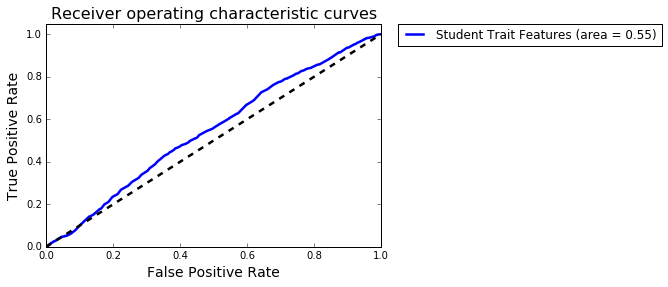

In [12]:
# Get a list of the raw prediction scores for the testing data
Y_score = logreg.decision_function(X_test)

# Get the false positive rates (FPR) and true posative rates (TPR)
fpr, tpr, _ = roc_curve(Y_test, Y_score)

# Calculate the AUC from the FPR and TPR
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, 'b', linewidth=2.5, label='Student Trait Features (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic curves', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 2.4 - Putting it all together
We will now build 2 functions which will do all of the work of steps 1 - 3 from the previous section.
* __train_classifier__ Takes the full dataframe and a list of columns to use as inputs and returns the classifier as well as the testing and training data in a tuple ```(classifier, training_data, testing_data)```.
  * training_data and testing_data are tuples of the form ```training_data = (X_train, Y_train)``` and ```testing_data = (X_test, Y_test)```.
* __test_classifier__ Takes the classifier, testing data, and an optional threshold as inputs and returns the total percent error, label 0 percent error, label 1 percent error, FPR, TPR, and AUC as a tuple ```(err_tot, err_0, err_1, fpr, tpr, auc)```.


Fill in the appropriate code for every instance of ```<fill in>``` using steps 1 - 3 from the previous section as examples.

In [13]:
def train_classifier(data_df, feature_list):
    # Define a list of column names to keep from the main dataset
    # We are specifically putting the classifcation label column "certified"
    # as the last element of the list
    features_label = feature_list + ["certified"]
    """features_label = <fill in>"""

    # Get a new dataframe that only contains columns from the features_label list
    cleaned_df = data_df[features_label]

    # Create a list of datapoints from the dataframe
    # Each element in the list will be a tuple with the form (label, features)
    # where label is either 1 or 0, and features is a list of the features from the dataframe
    clean_datapoints = map(list, cleaned_df.values)
    clean_labeledpoints = [(x[-1], x[:-1]) for x in clean_datapoints]

    Y_all = [x[0] for x in clean_labeledpoints]
    X_all = [x[1] for x in clean_labeledpoints]

    X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=.2, random_state=0)
    """X_train, X_test, Y_train, Y_test = <fill in>"""
    
    # Create a logistic regression model from scikit learn
    logreg = linear_model.LogisticRegression()
    """logreg = <fill in>"""

    # Fit the logistic regression model using the training data
    logreg.fit(X_train, Y_train)
    """logreg.<fill in>"""
    
    return (logreg, (X_train, Y_train), (X_test, Y_test))

In [14]:
def test_classifier(classifier, testing_data, threshold=0.5):
    from sklearn.metrics import roc_curve, auc

    # Unpack features and lables from testing data
    (X_test, Y_test) = testing_data
    
    # We want to get a list of predictions (0,1) for our list of testing data
    Y_pred = [1.0 if i[1] >= threshold else 0.0 for i in classifier.predict_proba(X_test)]

    # Total number of testing points
    N = len(Y_test)

    # Total number of 0 and 1 label testing points
    N_0_label = sum([1 if y==0.0 else 0 for y in Y_test])
    N_1_label = sum([1 if y==1.0 else 0 for y in Y_test])

    # Get the total number of incorrectly predicted testing points
    N_tot_incorrect = sum([1 if Y_pred[i]!=Y_test[i] else 0 for i in range(len(Y_test))])

    # Get the number of incorrectly predicted label 0 and 1 testing points
    N_0_incorrect = sum([1 if (Y_pred[i]!=Y_test[i]) and (Y_test[i]==0.0) else 0 for i in range(len(Y_test))])
    N_1_incorrect = sum([1 if (Y_pred[i]!=Y_test[i]) and (Y_test[i]==1.0) else 0 for i in range(len(Y_test))])

    # Compute total percent error
    err_tot = 100.0*N_tot_incorrect / float(N)
    """err_tot = <fill in>"""
    
    # Compute percent error for 0 and 1 labels
    err_0 = 100*N_0_incorrect / float(N_0_label)
    err_1 = 100*N_1_incorrect / float(N_1_label)
    """err_0 = <fill in>"""
    """err_1 = <fill in>"""
    
    # Compute TPR and FPR for the threshold
    # Recall: TPR = (number of correctly predicted 1 labels) / (total number of 1 labels)
    # Recall: FPR = (number of incorrectly predicted 0 labels) / (total number of 0 labels)
    this_tpr = (N_1_label - N_1_incorrect) / float(N_1_label)
    this_fpr = (N_0_incorrect) / float(N_0_label)
    """this_tpr = <fill in>"""
    """this_fpr = <fill in>"""

    print(str(N)+" total testing points")
    print("%.2f percent 0 labels" % (N_0_label*100.0/float(N)))
    print("%.2f percent 1 labels" % (N_1_label*100.0/float(N)))
    print("\nTotal percent error   -> %.2f" % (err_tot))
    print("Label 0 percent error -> %.2f" % (err_0))
    print("Label 1 percent error -> %.2f" % (err_1))
    
    # Get a list of the raw prediction scores for the testing data
    Y_score = classifier.decision_function(X_test)
    """Y_score = <fill in>"""

    # Get the false positive rates (FPR) and true posative rates (TPR)
    fpr, tpr, _ = roc_curve(Y_test, Y_score)
    """fpr, tpr, _ = <fill in>"""

    # Calculate the AUC from the FPR and TPR
    roc_auc = auc(fpr, tpr)
    """roc_auc = <fill in>"""

    plt.figure()
    plt.plot(fpr, tpr, 'b', linewidth=2.5, label='Current ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2.5)
    plt.plot(this_fpr, this_tpr, 'ro', linewidth=3, label="Current Threshold = %0.2f" % threshold)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver operating characteristic curves', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    return (err_tot, err_0, err_1, fpr, tpr, roc_auc)

In [1]:
t = 5
print t
print t/2
print t/float(2)

5
2
2.5


### 2.4.1 - Testing our new functions to recreate the classifier using student_trait_features
Now that we have our functions __train_classifier__ and __test_classifier__ defined, let's try to recreate our previous results training a classifier using only __student_trait_features__. 

107129 total testing points
97.40 percent 0 labels
2.60 percent 1 labels

Total percent error   -> 2.60
Label 0 percent error -> 0.00
Label 1 percent error -> 100.00


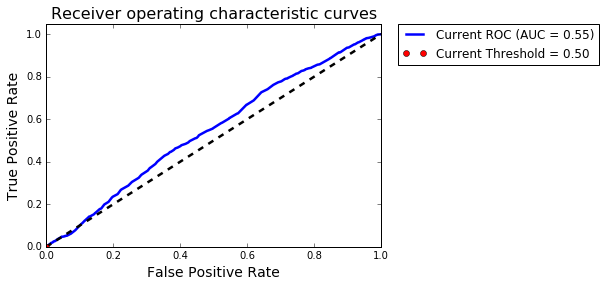

In [15]:
(classifier, training_data, testing_data) = train_classifier(cleaned_df_all, student_trait_features)
(err_tot, err_0, err_1, fpr, tpr, auc) = test_classifier(classifier, testing_data)

### 2.4.2 - Using our new functions to compare ROC curves for our 3 features groups
Let's now use our functions __train_classifier__ and __test_classifier__ to obtain fpr, tpr, and auc data for each of our three groups of features:
```
student_trait_features      = ["english_speaking", "education", "Age"]
course_interaction_features = ["nplay_video", "nforum_posts"]
super_features              = ["nevents", "nchapters"]
```

We will then plot ROC curves for all three features groups on the same plot for comparision.

As before, fill in the appropriate code for every instance of ```<fill in>```.

107129 total testing points
97.40 percent 0 labels
2.60 percent 1 labels

Total percent error   -> 8.62
Label 0 percent error -> 6.33
Label 1 percent error -> 94.54


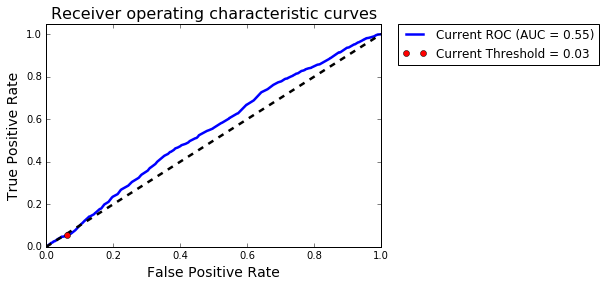

'(err_tot, err_0, err_1, fpr_st, tpr_st, auc_st) = <fill in>'

In [16]:
# student_trait_features
(classifier, training_data, testing_data) = train_classifier(cleaned_df_all, student_trait_features)
(err_tot, err_0, err_1, fpr_st, tpr_st, auc_st) = test_classifier(classifier, testing_data, threshold = 0.03)
"""(classifier, training_data, testing_data) = <fill in>"""
"""(err_tot, err_0, err_1, fpr_st, tpr_st, auc_st) = <fill in>"""

107129 total testing points
97.40 percent 0 labels
2.60 percent 1 labels

Total percent error   -> 12.60
Label 0 percent error -> 12.13
Label 1 percent error -> 30.29


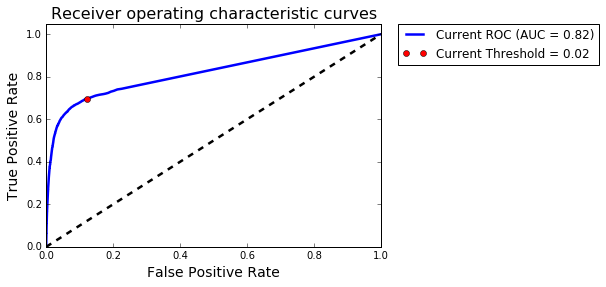

'(err_tot, err_0, err_1, fpr_ci, tpr_ci, auc_ci) = <fill in>'

In [17]:
# course_interaction_features
(classifier, training_data, testing_data) = train_classifier(cleaned_df_all, course_interaction_features)
(err_tot, err_0, err_1, fpr_ci, tpr_ci, auc_ci) = test_classifier(classifier, testing_data, threshold = 0.018)
"""(classifier, training_data, testing_data) = <fill in>"""
"""(err_tot, err_0, err_1, fpr_ci, tpr_ci, auc_ci) = <fill in>"""

107129 total testing points
97.40 percent 0 labels
2.60 percent 1 labels

Total percent error   -> 3.83
Label 0 percent error -> 3.81
Label 1 percent error -> 4.38


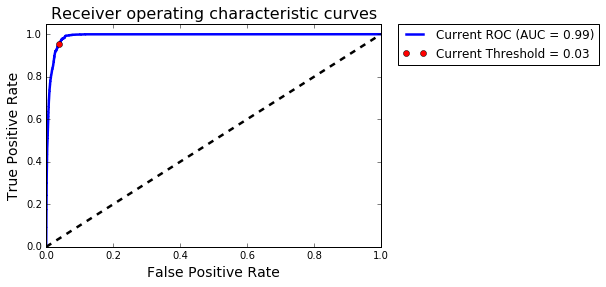

'(err_tot, err_0, err_1, fpr_sf, tpr_sf, auc_sf) = <fill in>'

In [18]:
# super_features
(classifier, training_data, testing_data) = train_classifier(cleaned_df_all, super_features)
(err_tot, err_0, err_1, fpr_sf, tpr_sf, auc_sf) = test_classifier(classifier, testing_data, threshold=0.03)
"""(classifier, training_data, testing_data) = <fill in>"""
"""(err_tot, err_0, err_1, fpr_sf, tpr_sf, auc_sf) = <fill in>"""

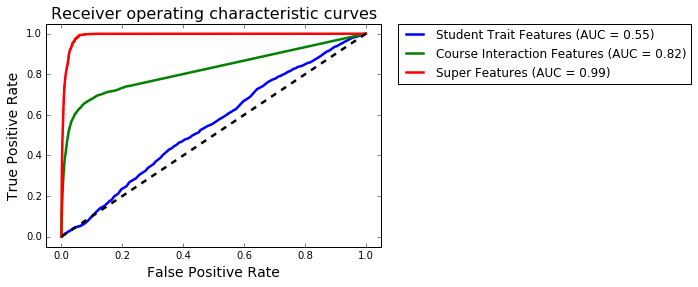

In [19]:
plt.figure()
plt.plot(fpr_st, tpr_st, 'b', linewidth=2.5, label='Student Trait Features (AUC = %0.2f)' % auc_st)
plt.plot(fpr_ci, tpr_ci, 'g', linewidth=2.5, label='Course Interaction Features (AUC = %0.2f)' % auc_ci)
plt.plot(fpr_sf, tpr_sf, 'r', linewidth=2.5, label='Super Features (AUC = %0.2f)' % auc_sf)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2.5)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic curves', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 2.5 - Binary Classification Conclusions
Several things were accomplished in this section.
Starting with a clean dataframe of data we have done the following:
1. Selected specific features from the data to obtain a list of labeled points ```(label, feature_list)```
2. Split the labeled points into training and testing datasets
3. Trained a logistic regression classifier using the training dataset
4. Tested the logistic regression classifier using the testing dataset with percent error metrics as well as ROC metrics
5. Combined steps 1-4 into simple functions
6. Used the simple functions to train classifiers for the three sets of features
7. Compared the three different classifiers using an ROC plot with calculated AUC values

---

# 3 - KMeans Clustering
A common type of unsupervised learning involves automatically clustering data based on the features.
We will now create clusters of students based on the features ```Age``` and ```nevents```.

As a first step, we will scale our features so that they are centered about their mean with unit standard deviations.
We will use the ```preprocessing``` function from ___scikit-learn___ to do this.

In [20]:
# Get dataframe keeping student trait features and course interaction features
# features  = cleaned_df_all[course_interaction_features]
features  = cleaned_df_all[["nevents", "Age"]]
certified = cleaned_df_all["certified"].tolist()
X_scaled  = preprocessing.scale(features)

## 3.1 - Basics of Kmeans Cluster
KMeans clustering is a simple method that takes data and a number of cluster centers ```k``` and returns the centers which best group the data.
A simple 2-d example is shown below [photo credit: Wikipedia].
![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/ClusterAnalysis_Mouse.svg/450px-ClusterAnalysis_Mouse.svg.png)
The raw data is shown in the left panel and the results of KMeans Clustering with ```k=3``` is shown in the middle panel.
A more advanced method, EM Clustering, is shown in the right panel, see [Expectation-maximation algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) for more details.

## 3.2 - Plot different sets of features in 2d
We will now make plots of ```nevents``` and ```Age``` features using certification to color the points.
This set of features will be used since there are only 2 features in it, making it easy to visualize.
KMeans clustering will then be used to try to group the data.

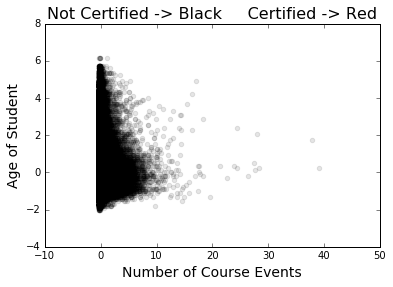

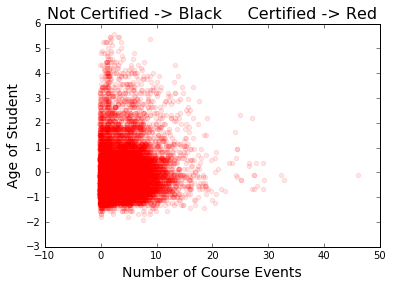

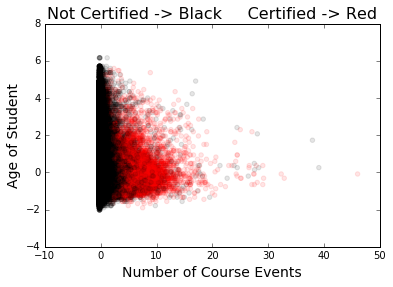

In [21]:
# Plot student traits (N_fourum_posts vs N_videos_watched)
x = [z[0] for z in X_scaled]
y = [z[1] for z in X_scaled]

# Define a function to make student's points red if they got certified
# and black if they did not get certified
def whatColor(label):
    if label == 0:
        return 'k'
    else:
        return 'r'
    
# Get a list of colors for the students to distinguish who got certified
c_plot = [whatColor(certified[i]) for i in range(len(certified))]

# Get individual lists of points for students who did and did not get certified
cert_0_x = []; cert_0_y = [];
cert_1_x = []; cert_1_y = [];
for i in range(len(c_plot)):
    if c_plot[i] == 'k':
        cert_0_x.append(x[i])
        cert_0_y.append(y[i])
    else:
        cert_1_x.append(x[i])
        cert_1_y.append(y[i]) 

# Plot only the students who did not get certified
plt.scatter(cert_0_x, cert_0_y, marker='o', color='k', alpha=0.1)
plt.xlabel('Number of Course Events', fontsize=14)
plt.ylabel('Age of Student', fontsize=14)
plt.title('Not Certified -> Black     Certified -> Red', fontsize=16)
plt.show()

# Plot only the students who did get certified
plt.scatter(cert_1_x, cert_1_y, marker='o', color='r', alpha=0.1)
plt.xlabel('Number of Course Events', fontsize=14)
plt.ylabel('Age of Student', fontsize=14)
plt.title('Not Certified -> Black     Certified -> Red', fontsize=16)
plt.show()

# Plot all students
plt.scatter(x, y, marker='o', color=c_plot, alpha=0.1)
plt.xlabel('Number of Course Events', fontsize=14)
plt.ylabel('Age of Student', fontsize=14)
plt.title('Not Certified -> Black     Certified -> Red', fontsize=16)
plt.show()

## 3.3 - Calculate KMeans for K=2..8 clusters and plot
We will now calculate the KMeans centers and average variance of points from centers for a range of cluster numbers.
We will then plot the average variance of datapoints from cluster centers as a function of the number of clusters used.

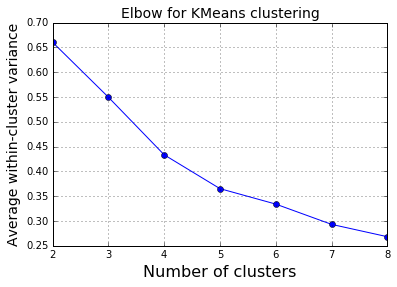

In [22]:
##### cluster data into K=2..8 clusters #####
K = range(2,9)
KM = [kmeans(X_scaled,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'bo-')
plt.grid(True)
plt.xlabel('Number of clusters', fontsize=16)
plt.ylabel('Average within-cluster variance', fontsize=14)
plt.title('Elbow for KMeans clustering', fontsize=14)
plt.show()

## 3.4 - Plot Cluster Centers with Raw Data
We now have a list of cluster centers for different numbers of clusters.
We will use this to plot cluster centers with the raw data to see how the cluster centers look.

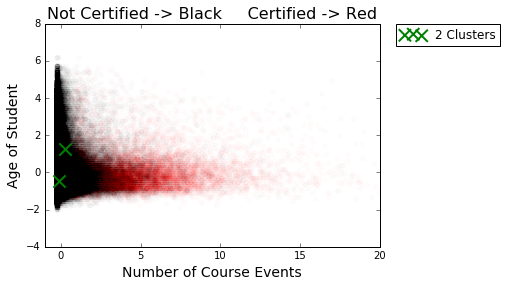

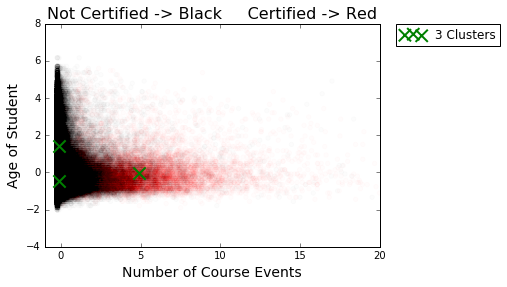

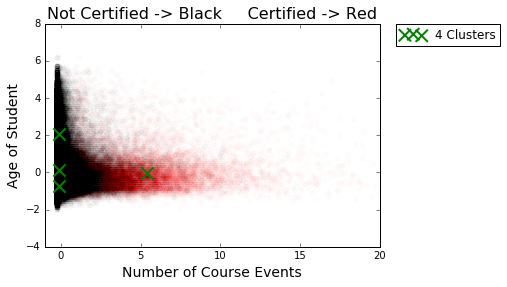

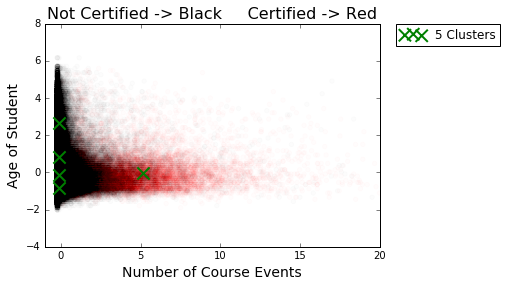

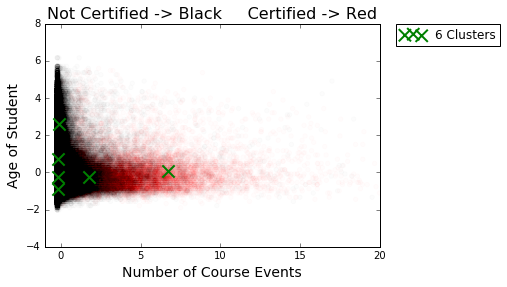

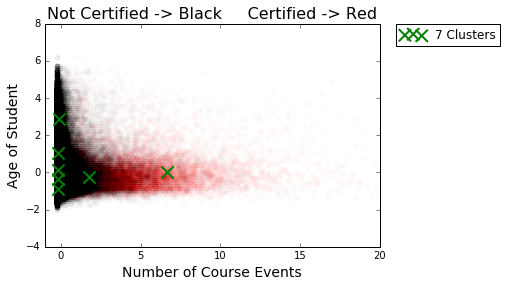

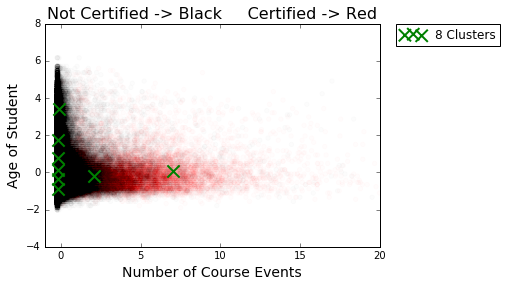

In [23]:
for i in range(len(centroids)):
    K_center = centroids[i]
    x_centers = [center[0] for center in K_center]
    y_centers = [center[1] for center in K_center]

    # Plot all students
    plt.scatter(x, y, marker='o', color=c_plot, alpha=0.01)
    plt.scatter(x_centers, y_centers, marker='x', s=150, linewidths=2, color='g', label=str(i+2)+" Clusters")
    plt.xlabel('Number of Course Events', fontsize=14)
    plt.ylabel('Age of Student', fontsize=14)
    plt.title('Not Certified -> Black     Certified -> Red', fontsize=16)
    plt.xlim([-1,20])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

## 3.5 - Clean data a bit and try again
It seems that the overwhelming number of datapoints with a grade of 0 is making the clusters weighted heavily for lower grades.
Let's try removing all data with ```grade == 0``` and redo the plots we just made.

In [24]:
## Get a new data set with only data that has grade != 0

# Get a dataframe with only "grade", "nevents", "Age", and "certified" columns from the cleaned_df_all dataframe
features_df  = cleaned_df_all[["grade", "nevents", "Age", "certified"]]
"""features_df = <fill in>"""

# Get a new dataframe "features_df_2" which only has rows from features_df which "grade" != 0
features_df_2 = features_df[features_df["grade"] != 0]
'''clean_features_df = <fill in>'''

# Get a list of the certified column from "features_df_2" dataframe
certified = features_df_2["certified"].tolist()
"""certified = <fill in>"""

# Scale the features "grade" and "Age" from "features_df_2" to be used for clustering
# You will have to only pass those columns from "features_df_2" to preprocessing
X_scaled  = preprocessing.scale(features_df_2[["nevents", "Age"]])
'''X_scaled = <fill in>'''

'X_scaled = <fill in>'

### 3.5.1 - Rerun the code to create a plot of average variance within clusters

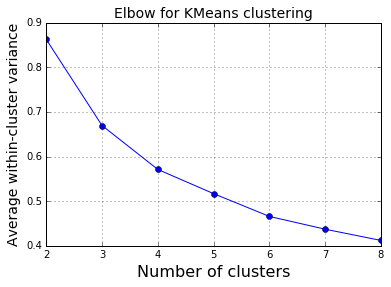

In [25]:
##### cluster data into K=2..8 clusters #####
K = range(2,9)
KM = [kmeans(X_scaled,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'bo-')
plt.grid(True)
plt.xlabel('Number of clusters', fontsize=16)
plt.ylabel('Average within-cluster variance', fontsize=14)
plt.title('Elbow for KMeans clustering', fontsize=14)
plt.show()

### 3.5.2 - Rerun the code to create plots of cluster centers with raw data

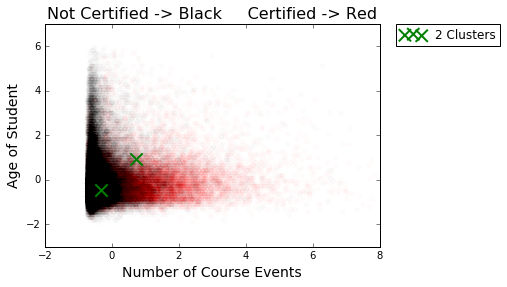

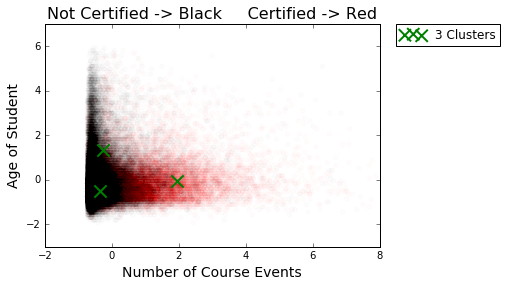

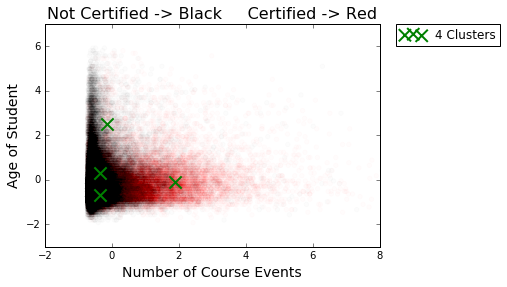

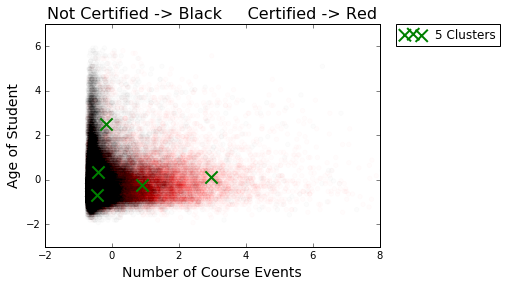

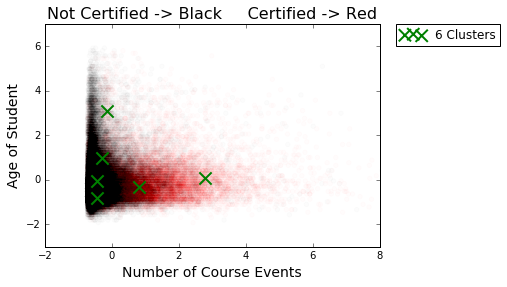

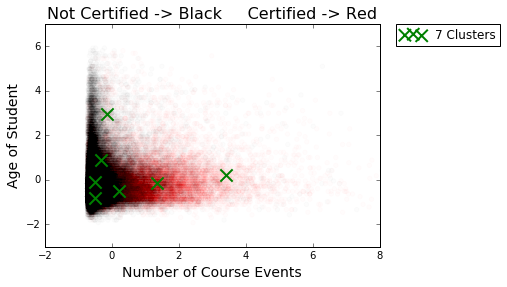

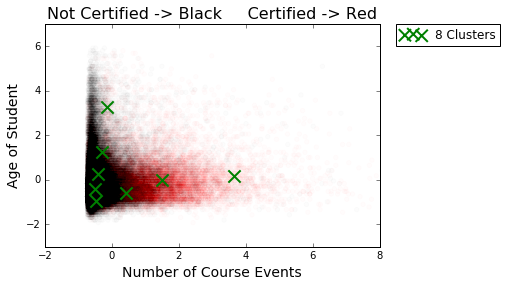

In [26]:
x = [z[0] for z in X_scaled]
y = [z[1] for z in X_scaled]
c_plot = [whatColor(certified[i]) for i in range(len(certified))]

for i in range(len(centroids)):
    K_center = centroids[i]
    x_centers = [center[0] for center in K_center]
    y_centers = [center[1] for center in K_center]

    # Plot all students
    plt.scatter(x, y, marker='o', color=c_plot, alpha=0.01)
    plt.scatter(x_centers, y_centers, marker='x', s=150, linewidths=2, color='g', label=str(i+2)+" Clusters")
    plt.xlabel('Number of Course Events', fontsize=14)
    plt.ylabel('Age of Student', fontsize=14)
    plt.title('Not Certified -> Black     Certified -> Red', fontsize=16)
    plt.xlim([-2,8])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

## 3.6 - KMeans Clustering Conclusions
In this section we have done the following:
1. Picked two continuous features, "grade" and "Age", to use for unsupervised learning using KMeans Clustering
2. Plotted "grade" vs "Age" while seperating students who recieved a certificate and those who did not using different colors
3. Trained a KMeans classifier using "grade" and "Age" for k=2..8 cluster centers
4. Plotted the cluster centers with the raw data
5. Cleaned our data to not include any students with "grade" == 0
6. Re-trained KMeans classifier using new cleaned data
7. Re-plotted new cluster centers with raw data